C:\Users\DavidShin\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.


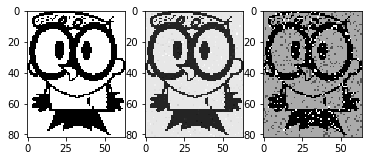

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import misc
import copy


def add_gaussian_noise(im,prop,varSigma):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    e = varSigma*np.random.randn(np.prod(im.shape)).reshape(im.shape)
    im2 = np.copy(im).astype('float')
    im2[index] += e[index]
    return im2

def add_saltnpeppar_noise(im,prop):
    N = int(np.round(np.prod(im.shape)*prop))
    index = np.unravel_index(np.random.permutation(np.prod(im.shape))[1:N],im.shape)
    im2 = np.copy(im)
    im2[index] = 1-im2[index]
    return im2

def binaryImage(image):
    cp_image = copy.deepcopy(image)
    for x in range(len(cp_image)):
        for y in range(len(cp_image[0])):
            cp_image[x][y] = round(cp_image[x][y])
            if cp_image[x][y] < 0.5:
                cp_image[x][y] = -1
    return cp_image
# proportion of pixels to alter

prop = 0.1
varSigma = 0.1
im = misc.imread('images/dexter.jpg')
im = im/255
im = binaryImage(im)
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(im,cmap='gray')
im2 = add_gaussian_noise(im,prop,varSigma)
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')
im3 = add_saltnpeppar_noise(im,prop)
ax3 = fig.add_subplot(133)
ax3.imshow(im3,cmap='gray')


In [5]:
def neighbours(i,j,M,N,size=4):
    if size==4:
        if (i==0 and j==0):
            n=[(0,1), (1,0)]
        elif i==0 and j==N-1:
            n=[(0,N-2), (1,N-1)]
        elif i==M-1 and j==0:
            n=[(M-1,1), (M-2,0)]
        elif i==M-1 and j==N-1:
            n=[(M-1,N-2), (M-2,N-1)]
        elif i==0:
            n=[(0,j-1), (0,j+1), (1,j)]
        elif i==M-1:
            n=[(M-1,j-1), (M-1,j+1), (M-2,j)]
        elif j==0:
            n=[(i-1,0), (i+1,0), (i,1)]
        elif j==N-1:
            n=[(i-1,N-1), (i+1,N-1), (i,N-2)]
        else:
            n=[(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
        return n
    if size==8:
        print('Not yet implemented\n')
        return -1

In [34]:
def calculateEnergy(latent, noisy, i, j, beta, eta):
    n = neighbours(i, j, latent.shape[0], latent.shape[1])
    energy = eta*(latent[i][j]*noisy[i][j])
    for m in n:
        x, y = m
        energy += beta * latent[x][y] * latent[i][j]
    return energy

def convertLatent(latent):
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == 0:
                latent[i][j] = -1
    return latent
    
def ICM(image, beta, eta, runs):
    latentImage = copy.deepcopy(image)
    latentImage = convertLatent(latentImage)
    for n in range(runs):
        print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                if posEnergy > negEnergy:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.8708644610458911


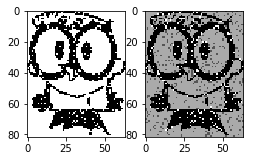

In [35]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im3, 1, 5, 2),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

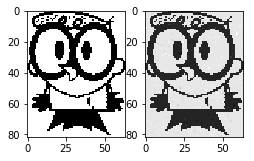

In [10]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(ICM(im2, 0, 1, 1),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

In [14]:
originalImage = convertLatent(im)
def totalBlack(image):
    black = 0
    for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                if image[i][j] == -1:
                    black += 1
    return black
def pixelPercentage(latent, real):    
    counter = 0
    totalPix = totalBlack(real)
    for i in range(latent.shape[0]):
        for j in range(latent.shape[1]):
            if latent[i][j] == -1 and real[i][j] == -1:
                counter += 1
    return counter/totalPix
    

In [13]:
import math
def gibbsy(image, beta, eta,runs):
    latentImage = copy.deepcopy(image)
    for n in range(runs):
        print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                latentImage[i][j] = 1
                posEnergy = math.exp(calculateEnergy(latentImage, image, i, j, beta, eta))
                latentImage[i][j] = -1
                negEnergy = math.exp(calculateEnergy(latentImage, image, i, j, beta, eta))
                post = posEnergy/(posEnergy + negEnergy)
                r = np.random.uniform(0,1)
                if post >= r:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage
                

                

In [17]:
def gibbs(image, beta, eta, runs):
    latentImage = np.random.randint(2, size=(image.shape))
    latentImage = convertLatent(latentImage)
    for n in range(runs):
        print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                posEnergy = np.exp(posEnergy)
                
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
                for m in bros:
                    x, y = m
                    negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                negEnergy = np.exp(negEnergy)
                joint = posEnergy/(posEnergy+negEnergy)
                negJoint = negEnergy/(posEnergy+negEnergy)
                r = np.random.uniform(0,1)
                if joint >= r:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
    return latentImage

PIXEL SIMILARITY: 0.9055496264674493
PIXEL SIMILARITY: 0.959445037353255
PIXEL SIMILARITY: 0.9423692636072573
PIXEL SIMILARITY: 0.9503735325506937
PIXEL SIMILARITY: 0.9525080042689434
PIXEL SIMILARITY: 0.9589114194236926
PIXEL SIMILARITY: 0.9471718249733191
PIXEL SIMILARITY: 0.9546424759871932
PIXEL SIMILARITY: 0.9450373532550693
PIXEL SIMILARITY: 0.9487726787620064


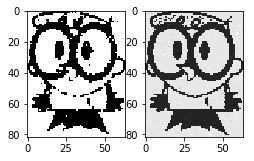

In [18]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbsy(im2, 0.5, 1, 10),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im2,cmap='gray')

PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.8991462113127001


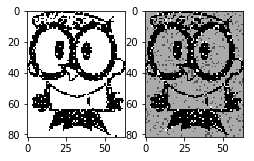

In [32]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbsy(im3, 1, 5, 2),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

PIXEL SIMILARITY: 0.5005336179295624
PIXEL SIMILARITY: 0.8665955176093917


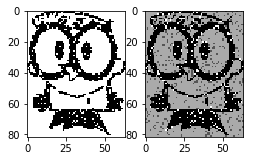

In [39]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(gibbs(im3, 1, 5, 2),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')

In [73]:
def sigma(val):
    
    if (1+np.exp(-2*val)) == 0:
        print("This is zero boy")
    
    return 1/(1+np.exp(-2*val))

def tanh(val):
    if (np.exp(val) + np.exp(val * -1)) == 0:
        print("This is zero as well")
    return (np.exp(val) - np.exp(val * -1)) / (np.exp(val) + np.exp(val * -1))


In [76]:
def VB(image, beta, eta, runs, weight):
    mu = np.zeros((image.shape[0], image.shape[1]))
    
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            mu[i][j] = np.random.uniform(-1, 1)
            
    latentImage = copy.deepcopy(image)
    
    for k in range(runs):
        print("PIXEL SIMILARITY: " + str(pixelPercentage(latentImage, originalImage)))
        for i in range(image.shape[0]):
            for j in range(image.shape[1]):
                bros = neighbours(i, j, latentImage.shape[0], latentImage.shape[1])
                
                m_val = 0
                for x, y in bros:
                    m_val += weight * mu[x][y]
                
                latentImage[i][j] = 1
                posEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
#                 for m in bros:
#                     x, y = m
#                     posEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                posEnergy = np.exp(posEnergy)
                
                latentImage[i][j] = -1
                negEnergy = calculateEnergy(latentImage, image, i,j, beta, eta)
#                 for m in bros:
#                     x, y = m
#                     negEnergy += calculateEnergy(latentImage, image, x, y, beta, eta)
                negEnergy = np.exp(negEnergy)
                
                
                mu_val = tanh(m_val + 0.5 * (posEnergy - negEnergy))
                
                mu[i][j] = mu_val
                
                posterior = sigma(m_val + 0.5 * (posEnergy - negEnergy))
                
                joint = posterior * mu_val
                
#                 print(posterior)
#                 print(joint)
                
                if posterior > 0.5:
                    latentImage[i][j] = 1
                else:
                    latentImage[i][j] = -1
                    
    return latentImage

PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123
PIXEL SIMILARITY: 0.9018143009605123


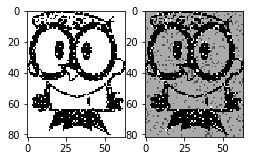

In [141]:
fig = plt.figure()
ax = fig.add_subplot(131)
ax.imshow(VB(im3, 0, 1, 10, 0.1),cmap='gray')
ax2 = fig.add_subplot(132)
ax2.imshow(im3,cmap='gray')